# Forecasting Energy Consumption Using Machine Learning

## Install xgboost

In [134]:
!pip install xgboost

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Read File

In [136]:
df = pd.read_csv('AEP_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

## Explore The Data

In [137]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


## Plot The Data

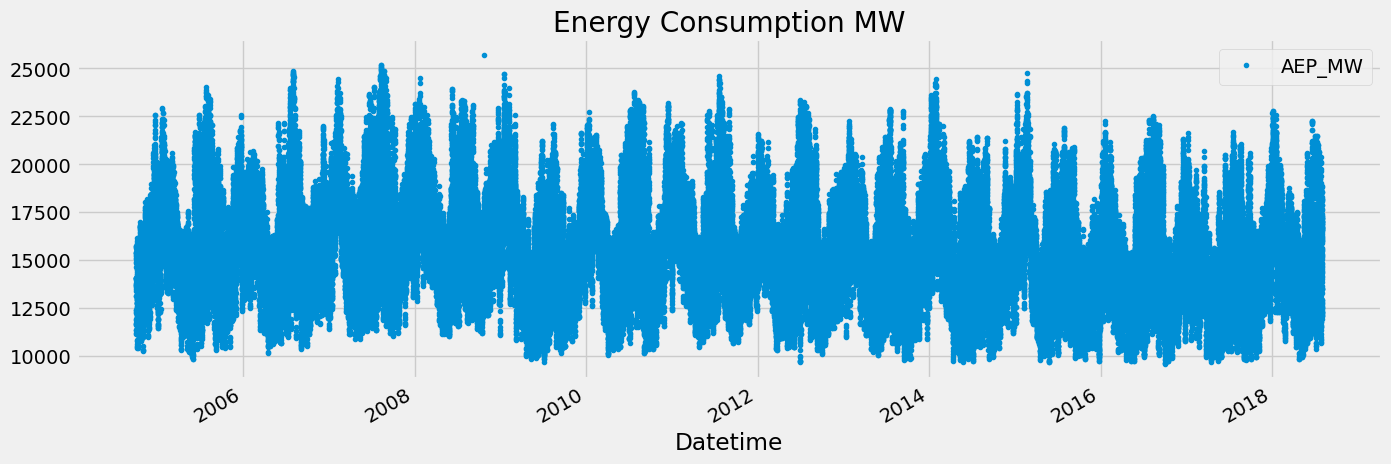

In [138]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Energy Consumption MW')
plt.show()

## Split Data into Train and Test Data

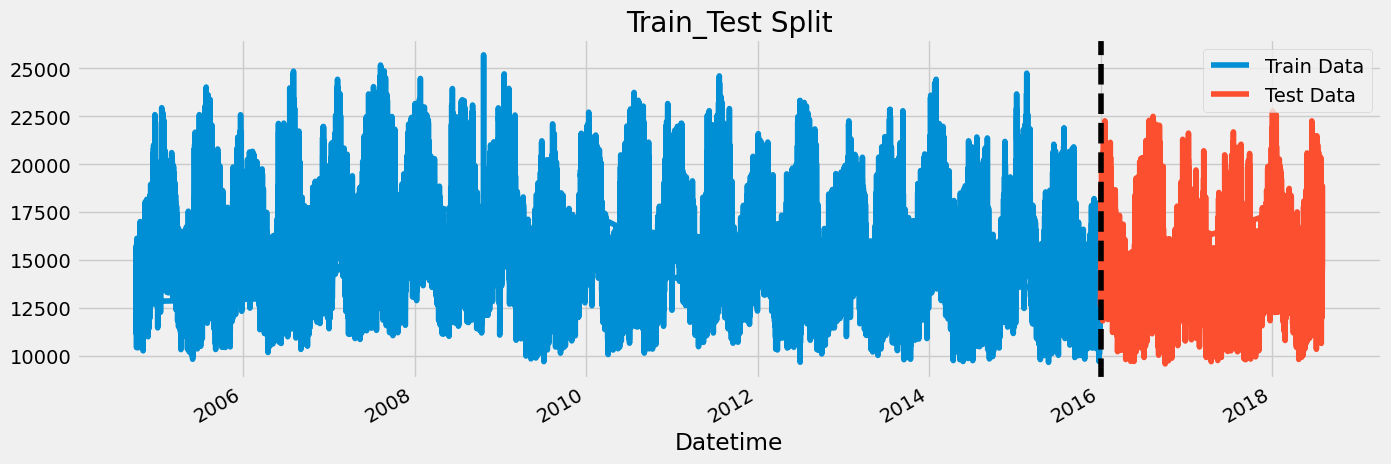

In [139]:
train = df.loc[df.index < '01-01-2016']
test = df.loc[df.index >= '01-01-2016']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Train Data', title='Train_Test Split')
test.plot(ax=ax, label='Test Data')
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Train Data', 'Test Data'])
plt.show()

## A plot of a Week of Data

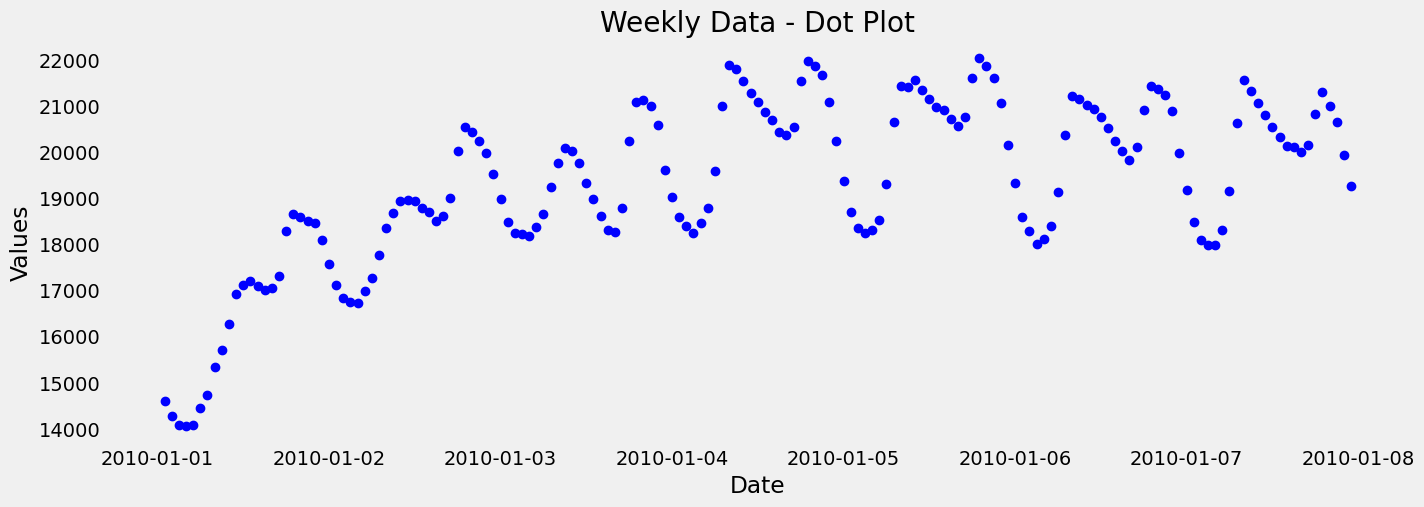

In [140]:
filtered_df = df.loc[(df.index > '2010-01-01') & (df.index < '2010-01-08')]

plt.figure(figsize=(15, 5))
plt.plot(filtered_df.index, filtered_df.values, 'o', color='blue')  # 'o' specifies circle markers
plt.title('Weekly Data - Dot Plot')
plt.xlabel('Date')  # Optional: Add x-axis label
plt.ylabel('Values')  # Optional: Add y-axis label
plt.grid()  # Optional: Add grid for better readability
plt.show()


## Create time series features based on time series index.

In [141]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## Plot of Hourly Consumption

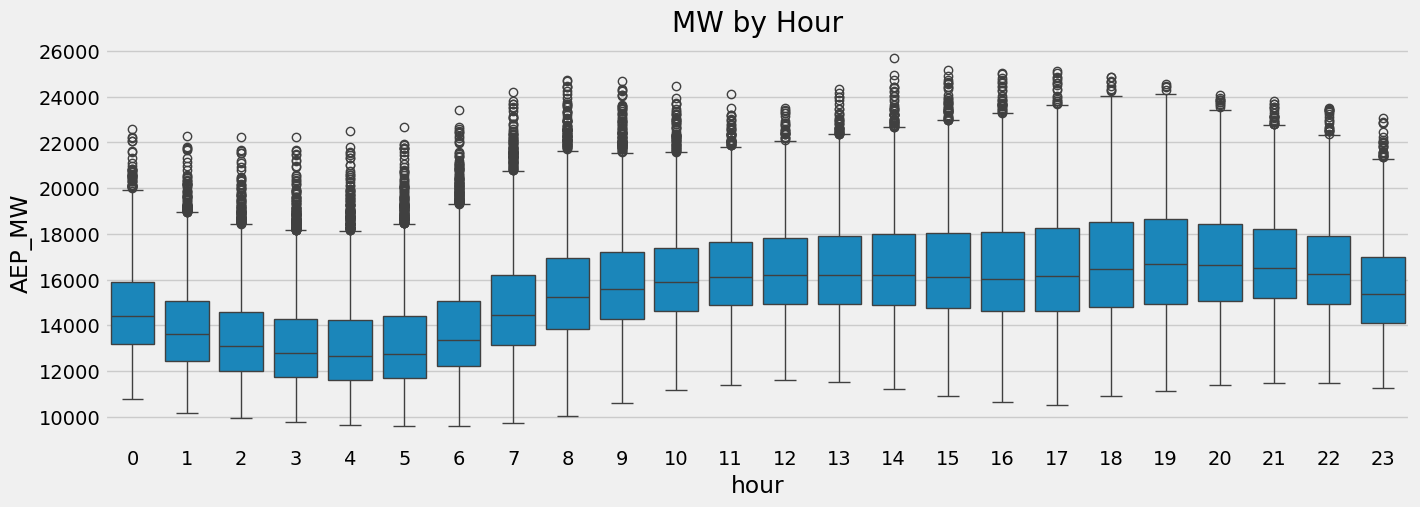

In [142]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

## Plot of Monthly Consumption

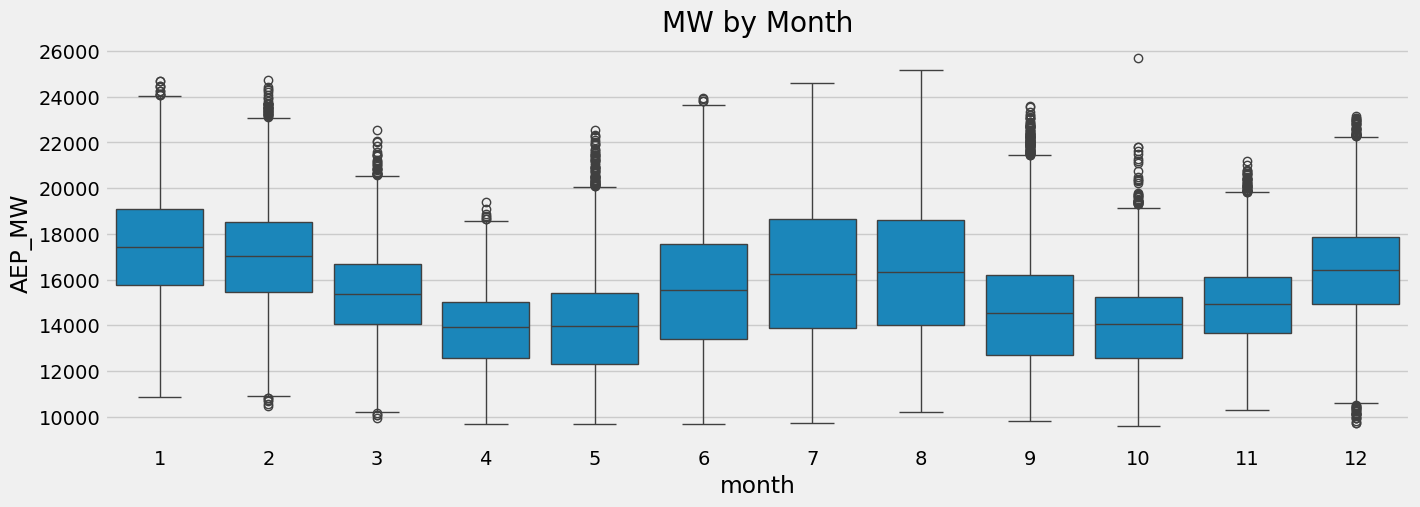

In [177]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='month', y='AEP_MW')
ax.set_title('MW by Month')
plt.show()

## Building The Model

In [143]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [144]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:15720.01909	validation_1-rmse:14831.79968


C:\Users\Khuthadzo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:43:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:6010.82493	validation_1-rmse:5186.35468
[200]	validation_0-rmse:2709.74331	validation_1-rmse:2239.96435
[300]	validation_0-rmse:1767.76258	validation_1-rmse:1742.63927
[391]	validation_0-rmse:1537.92410	validation_1-rmse:1731.65098


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Feature Importance

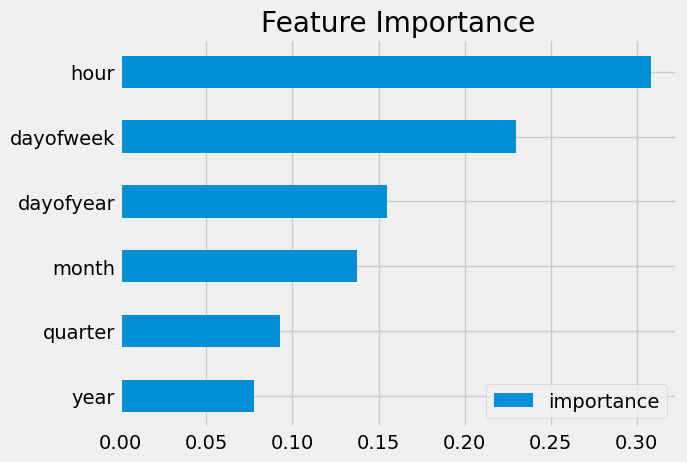

In [145]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Evaluation of Predicted results on Real Data

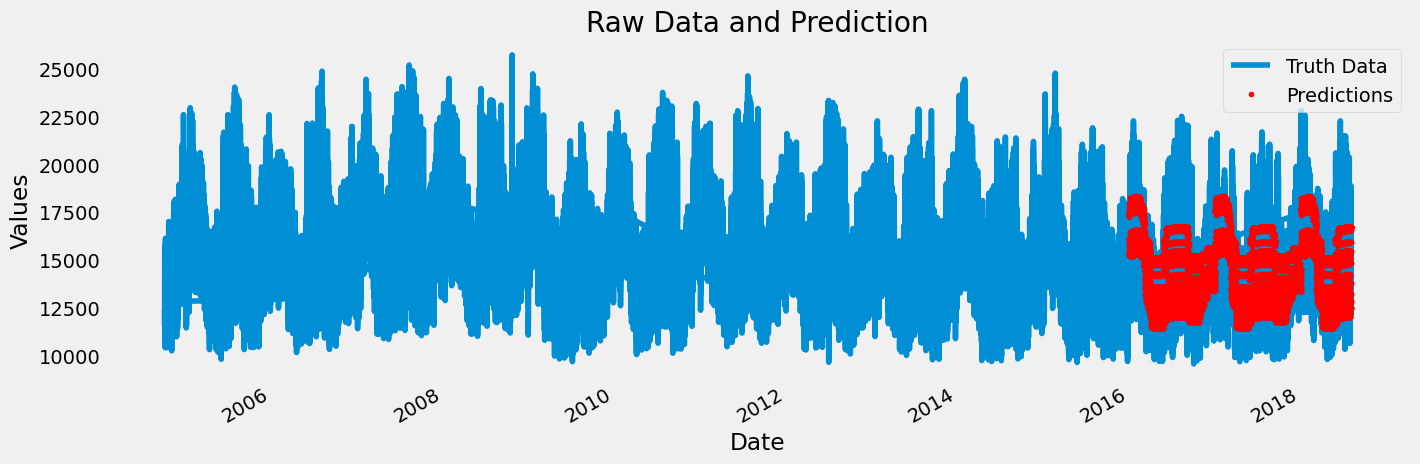

In [147]:
test['prediction'] = reg.predict(X_test)
test.rename(columns={'prediction': 'test_prediction1'}, inplace=True)

df = df.merge(test[['test_prediction1']], how='left', left_index=True, right_index=True)

ax = df[['AEP_MW']].plot(figsize=(15, 5))

df['test_prediction1'].plot(ax=ax, style='.', color='red')

plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.xlabel('Date')  # Optional: Add x-axis label
plt.ylabel('Values')  # Optional: Add y-axis label
plt.grid()  # Optional: Add grid for better readability
plt.show()

## Evaluation of Predicted Results on Real Data for one Week

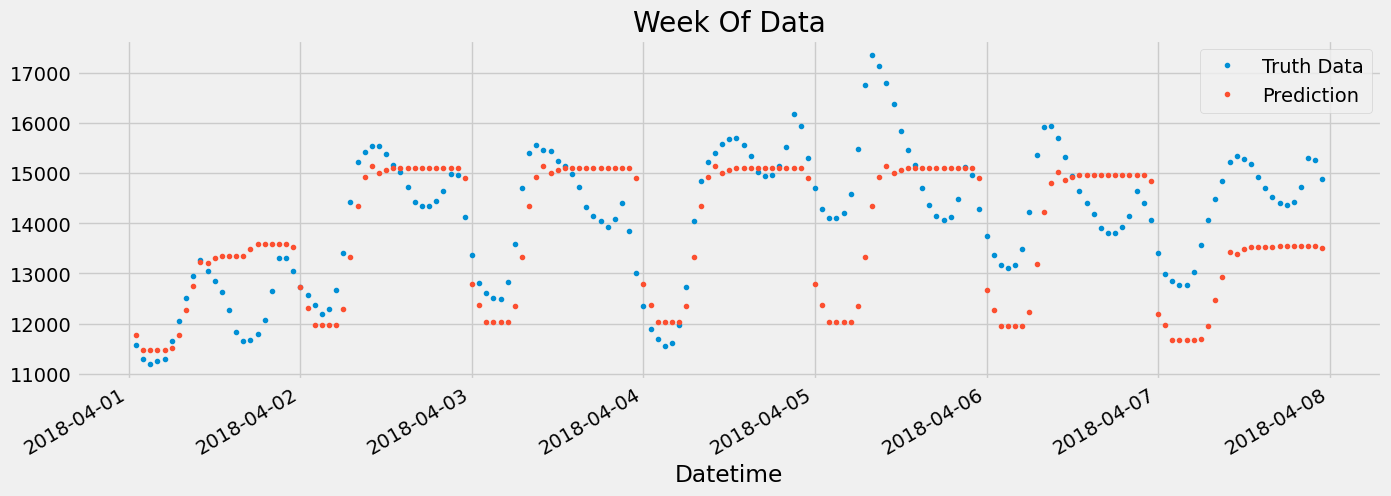

In [148]:
ax = df.loc[(df.index > '2018-04-01') & (df.index < '2018-04-08')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data', style='.')
df.loc[(df.index > '2018-04-01') & (df.index < '2018-04-08')]['prediction'] \
    .plot(style='.')

plt.legend(['Truth Data', 'Prediction'])
plt.show()

## Evalution of Model

In [153]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['test_prediction1']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1724.82


## Worse and Best Predictions

In [155]:
test['error'] = np.abs(test[TARGET] - test['test_prediction1'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2018-01-06    4757.119385
2016-12-16    4556.293498
2017-12-28    4449.694417
2017-12-31    4415.405680
2016-12-15    4176.898844
2018-01-07    4030.905029
2018-01-05    3960.001709
2018-01-02    3891.844686
2017-02-24    3758.676799
2016-08-12    3707.427612
Name: error, dtype: float64

# Future Predictions

## Creating Features and Target

In [157]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:15559.12995


C:\Users\Khuthadzo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:43:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:5963.28746
[200]	validation_0-rmse:2708.84503
[300]	validation_0-rmse:1787.00212
[400]	validation_0-rmse:1556.61916
[499]	validation_0-rmse:1478.70211


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Getting The End Date of The Raw Data

In [159]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

## Making Future Energy Consumption Prediction for The Next Two Years

In [179]:
future = pd.date_range('2018-08-03','2020-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
#df_and_future = add_lags(df_and_future)

In [181]:
future_w_features = df_and_future.query('isFuture').copy()

In [183]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

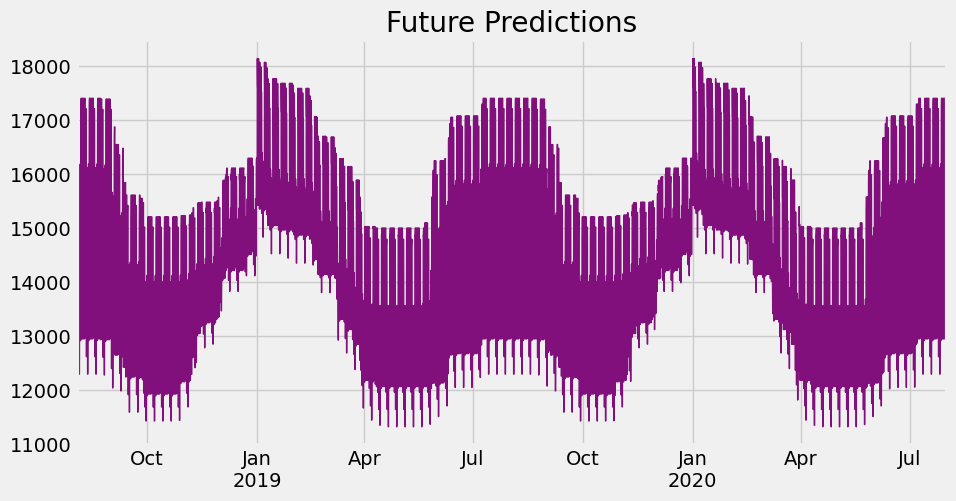

In [189]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[-1],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()
